In [1]:
# Adi Pradhan
# ZTDL Bootcamp Sep 2018
# Predicting the Price of BTC using an LSTM 
%reset -f
#libraries

import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from keras.utils import to_categorical
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# read the csvs
df1 = pd.read_csv('data/data.part1.csv',index_col=0)
df2 = pd.read_csv('data/data.part2.csv',index_col=0)
df = pd.concat([df1,df2])

In [3]:
# create a Pandas Series with index as the date and data as the mean price in that day
df['timestamp_hour'] = pd.to_datetime(df['Timestamp'],unit='s')
df['timestamp_hour'] = pd.to_datetime(df['timestamp_hour'])
df = df.set_index(['timestamp_hour'])
df_price = df.resample('H').mean()
df_price = df_price.drop(['Timestamp','Open','High','Low','Close'],axis=1)
df_price = df_price.dropna()

In [4]:
df_price['Next_Weighted_Price'] = df_price['Weighted_Price'].shift(-1)
df_price = df_price[1:]
df_price = df_price[:-1]

In [5]:
df_price.head()

,Volume_(BTC),Volume_(Currency),Weighted_Price,Next_Weighted_Price
timestamp_hour,,,,
2014-12-01 06:00:00,0.012759,4.440925,342.0,370.0
2014-12-01 07:00:00,0.026556,9.825550,370.0,370.0
2014-12-01 08:00:00,0.026556,9.825550,370.0,370.0
2014-12-01 09:00:00,0.026556,9.825550,370.0,370.0
2014-12-01 10:00:00,0.026556,9.825550,370.0,370.0


In [6]:
df_price.tail()

,Volume_(BTC),Volume_(Currency),Weighted_Price,Next_Weighted_Price
timestamp_hour,,,,
2018-06-26 19:00:00,5.099909,31472.865848,6172.690783,6183.871078
2018-06-26 20:00:00,3.596994,22243.274211,6183.871078,6187.186309
2018-06-26 21:00:00,6.424415,39870.424767,6187.186309,6155.090729
2018-06-26 22:00:00,14.184668,87228.573942,6155.090729,6113.676832
2018-06-26 23:00:00,16.170982,98388.359578,6113.676832,6073.969960


In [7]:
df_price['up_or_down'] = df_price.apply(lambda row: 1 if row['Next_Weighted_Price'] > row['Weighted_Price'] else 0,axis=1)

In [8]:
# most interesting man (coin flip prediction)
df_price['coin_flip'] = np.random.randint(0,2,size=df_price.shape[0])

# yoda (always HODL - optimist)
df_price['optimistic_prediction'] = 1

df_price.head()

,Volume_(BTC),Volume_(Currency),Weighted_Price,Next_Weighted_Price,up_or_down,coin_flip,optimistic_prediction
timestamp_hour,,,,,,,
2014-12-01 06:00:00,0.012759,4.440925,342.0,370.0,1,0,1
2014-12-01 07:00:00,0.026556,9.825550,370.0,370.0,0,0,1
2014-12-01 08:00:00,0.026556,9.825550,370.0,370.0,0,1,1
2014-12-01 09:00:00,0.026556,9.825550,370.0,370.0,0,1,1
2014-12-01 10:00:00,0.026556,9.825550,370.0,370.0,0,1,1


In [9]:
pd.DataFrame.corr(df_price)

,Volume_(BTC),Volume_(Currency),Weighted_Price,Next_Weighted_Price,up_or_down,coin_flip,optimistic_prediction
Volume_(BTC),1.000000,0.678392,0.312026,0.312536,0.006270,-0.000676,NaN
Volume_(Currency),0.678392,1.000000,0.630418,0.630953,-0.000442,0.002706,NaN
Weighted_Price,0.312026,0.630418,1.000000,0.999901,-0.004682,0.001470,NaN
Next_Weighted_Price,0.312536,0.630953,0.999901,1.000000,-0.000234,0.001509,NaN
up_or_down,0.006270,-0.000442,-0.004682,-0.000234,1.000000,-0.000257,NaN
coin_flip,-0.000676,0.002706,0.001470,0.001509,-0.000257,1.000000,NaN
optimistic_prediction,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
(df_price['coin_flip']==df_price['up_or_down']).value_counts()/len(df_price)

False    0.500115
True     0.499885
dtype: float64

Therefore the coin flip has 50.4% accuracy

In [11]:
(df_price['optimistic_prediction']==df_price['up_or_down']).value_counts()/len(df_price)

True     0.529827
False    0.470173
dtype: float64

Therefore the optimistic view has 51% accuracy

In [12]:
# Get the right series for prediction 
X = df_price[['Weighted_Price','Volume_(BTC)']]
y = df_price['up_or_down']

In [13]:
# for train test split we will take Mar, Apr and May 2018 as the test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24260, 2)
(6065, 2)
(24260,)
(6065,)


In [14]:
from sklearn.preprocessing import MinMaxScaler
mx = MinMaxScaler()
X_train_rs = X_train.values.reshape(-1,2)
X_test_rs = X_test.values.reshape(-1,2)
X_train_sc = mx.fit_transform(X_train_rs)
X_test_sc = mx.transform(X_test_rs)
X_train_sc.shape

(24260, 2)

In [15]:
X_train_sc_df = pd.DataFrame(X_train_sc,columns=['Price','Volume'])
X_test_sc_df = pd.DataFrame(X_test_sc,columns=['Price','Volume'])
X_train_sc_df.describe()

,Price,Volume
count,24260.000000,24260.000000
mean,0.143152,0.011832
std,0.194584,0.017491
min,0.000000,0.000000
25%,0.023698,0.005214
50%,0.066520,0.008427
75%,0.151499,0.013775
max,1.000000,1.000000


In [16]:
window_size = 24*7*4
for s in np.arange(1,window_size+1):
    X_train_sc_df['shift_{}'.format(s)] = X_train_sc_df['Price'].shift(s)
    X_test_sc_df['shift_{}'.format(s)] = X_test_sc_df['Price'].shift(s)

In [17]:
X_train_sc_df.head(n=30)

,Price,Volume,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,...,shift_663,shift_664,shift_665,shift_666,shift_667,shift_668,shift_669,shift_670,shift_671,shift_672
0,0.034600,0.000024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.039518,0.000051,0.034600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.039518,0.000051,0.039518,0.034600,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.039518,0.000051,0.039518,0.039518,0.034600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.039518,0.000051,0.039518,0.039518,0.039518,0.034600,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.039518,0.000051,0.039518,0.039518,0.039518,0.039518,0.034600,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.039518,0.000051,0.039518,0.039518,0.039518,0.039518,0.039518,0.034600,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.039518,0.000051,0.039518,0.039518,0.039518,0.039518,0.039518,0.039518,0.034600,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.039518,0.000051,0.039518,0.039518,0.039518,0.039518,0.039518,0.039518,0.039518,0.034600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.039518,0.000051,0.039518,0.039518,0.039518,0.039518,0.039518,0.039518,0.039518,0.039518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:

X_train_sc_df = X_train_sc_df[window_size:]
y_train = y_train[window_size:]

X_test_sc_df = X_test_sc_df[window_size:]
y_test = y_test[window_size:]

X_train_final = X_train_sc_df.values.reshape(-1, window_size+2, 1)
y_train_cat = to_categorical(y_train.values)


X_test_final = X_test_sc_df.values.reshape(-1,window_size+2,1)
y_test_cat = to_categorical(y_test.values)



In [19]:
X_train.shape

(24260, 2)

In [20]:
from keras.layers import Dense, CuDNNLSTM, Dropout
from keras import Sequential
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(CuDNNLSTM(32,input_shape=(window_size+2,1),return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(32))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 674, 32)           4480      
_________________________________________________________________
dropout_1 (Dropout)          (None, 674, 32)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total para

In [21]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
early_stop = EarlyStopping(monitor='loss',patience=10,verbose=1)

In [22]:
h = model.fit(X_train_final,y_train_cat,epochs=200,batch_size=1024,callbacks=[early_stop],verbose=1,validation_split=0.1)

Train on 21229 samples, validate on 2359 samples
Epoch 1/200
21229/21229 [==============================] - 8s 389us/step - loss: 0.6912 - acc: 0.5353 - val_loss: 0.6913 - val_acc: 0.5418
Epoch 2/200
21229/21229 [==============================] - 6s 283us/step - loss: 0.6902 - acc: 0.5377 - val_loss: 0.6912 - val_acc: 0.5418
Epoch 3/200
21229/21229 [==============================] - 6s 280us/step - loss: 0.6907 - acc: 0.5377 - val_loss: 0.6904 - val_acc: 0.5418
Epoch 4/200
21229/21229 [==============================] - 6s 280us/step - loss: 0.6907 - acc: 0.5377 - val_loss: 0.6900 - val_acc: 0.5418
Epoch 5/200
21229/21229 [==============================] - 6s 280us/step - loss: 0.6903 - acc: 0.5377 - val_loss: 0.6905 - val_acc: 0.5418
Epoch 6/200
21229/21229 [==============================] - 6s 281us/step - loss: 0.6905 - acc: 0.5377 - val_loss: 0.6900 - val_acc: 0.5418
Epoch 7/200
21229/21229 [==============================] - 6s 277us/step - loss: 0.6904 - acc: 0.5377 - val_loss: 0.6

In [23]:
model.evaluate(X_train_final,y_train_cat)

23588/23588 [==============================] - 60s 3ms/step


[0.6900192819976677, 0.5381125996269289]

In [24]:
model.evaluate(X_test_final,y_test_cat)

5393/5393 [==============================] - 14s 3ms/step


[0.6979025133394828, 0.4800667532649041]

In [25]:
y_pred = model.predict(X_test_final)

In [26]:
y_pred_classes = np.argmax(y_pred,axis=1)

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred_classes)

0.48006675319859077

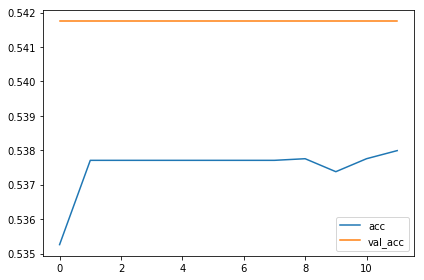

In [28]:
pd.DataFrame(h.history)[['acc','val_acc']].plot()
plt.tight_layout()